#spc charts
#simulate new data
#create an automated web based dashboard

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
data = pd.read_csv('manufacturing_process_data.csv')
print(data.head())
print(data.columns)

data_lineA = data[data['Line'] == 'Line A']

   Record_ID        Date      Shift    Line  Production_Volume  \
0          1  2023-01-02    Morning  Line A                376   
1          2  2023-01-02  Afternoon  Line A                384   
2          3  2023-01-02      Night  Line A                359   
3          4  2023-01-03    Morning  Line A                382   
4          5  2023-01-03  Afternoon  Line A                367   

   Average_Cycle_Time  Defects_Total  Defect_Rate  Downtime_Total  \
0               64.88              2       0.0053        2.691049   
1               66.32              1       0.0026        0.000000   
2               62.28              0       0.0000        0.803694   
3               66.04              2       0.0052        4.682059   
4               65.32              3       0.0082        4.639611   

   Defects_Dimensional  ...  Quality_RTY  Quality_Sigma_Level  \
0                    1  ...       0.9920                  6.0   
1                    1  ...       0.9961                  

In [63]:
# Prepare dataframe (use existing data_lineA)
df = data_lineA.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

Text(0.5, 0, 'Date')

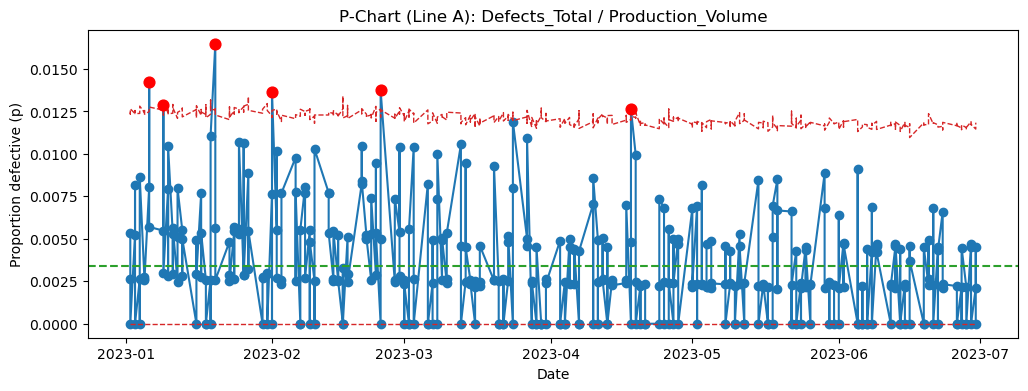

In [64]:
#P-Chart for Defects_Total / Production_Volume
p_bar = df['Defects_Total'].sum() / df['Production_Volume'].sum()
df['p'] = df['Defects_Total'] / df['Production_Volume']
df['UCL'] = p_bar + 3 * np.sqrt((p_bar * (1 - p_bar)) / df['Production_Volume'])
df['LCL'] = p_bar - 3 * np.sqrt((p_bar * (1 - p_bar)) / df['Production_Volume'])

plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['p'], marker='o', linestyle='-', color='C0', label='p (Defects/Production)')
plt.axhline(p_bar, color='C2', linestyle='--', linewidth=1.5, label=f'Center p̄ = {p_bar:.4f}')
plt.plot(df['Date'], df['UCL'], color='C3', linestyle='--', linewidth=1, label='UCL')
plt.plot(df['Date'], df['LCL'].clip(lower=0), color='C3', linestyle='--', linewidth=1, label='LCL (clipped at 0)')
ooc_mask = (df['p'] > df['UCL']) | (df['p'] < df['LCL'])
plt.scatter(df['Date'][ooc_mask], df['p'][ooc_mask], color='red', s=60, zorder=5, label='OOC')
plt.title('P-Chart (Line A): Defects_Total / Production_Volume')
plt.ylabel('Proportion defective (p)')
plt.xlabel('Date')

Text(0.5, 1.0, 'I-MR Chart (Line A): Cycle Time')

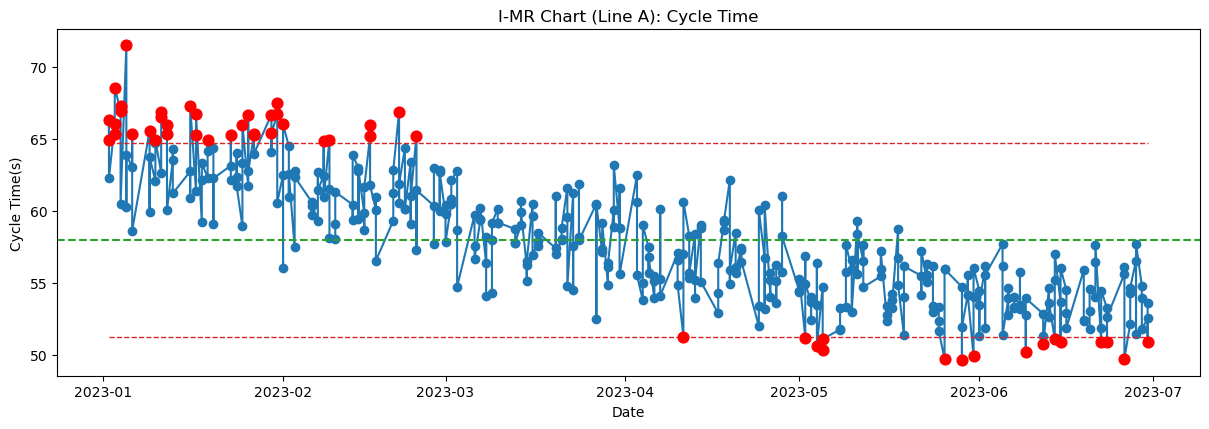

In [65]:
#I-MR Chart for Cycle_Time
df['Cycle_Time_Mean'] = df['Average_Cycle_Time'].mean()
df['MR'] = df['Average_Cycle_Time'].diff().abs()
MR_bar = df['MR'].mean()
df['UCL_I'] = df['Cycle_Time_Mean'] + 3 * (MR_bar / 1.128)
df['LCL_I'] = df['Cycle_Time_Mean'] - 3 * (MR_bar / 1.128)

plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Average_Cycle_Time'], marker='o', linestyle='-', color='C0', label='Cycle Time')
plt.axhline(df['Cycle_Time_Mean'].iloc[0], color='C2', linestyle='--', linewidth=1.5, label=f'Center Mean = {df["Cycle_Time_Mean"].iloc[0]:.2f}')
plt.plot(df['Date'], df['UCL_I'], color='C3', linestyle='--', linewidth=1, label='UCL')
plt.plot(df['Date'], df['LCL_I'].clip(lower=0), color='C3', linestyle='--', linewidth=1, label='LCL (clipped at 0)')
ooc_mask_I = (df['Average_Cycle_Time'] > df['UCL_I']) | (df['Average_Cycle_Time'] < df['LCL_I'])
plt.scatter(df['Date'][ooc_mask_I], df['Average_Cycle_Time'][ooc_mask_I], color='red', s=60, zorder=5)
plt.tight_layout()
plt.ylabel('Cycle Time(s)')
plt.xlabel('Date')
plt.title('I-MR Chart (Line A): Cycle Time')

Text(0.5, 14.722222222222216, 'Date')

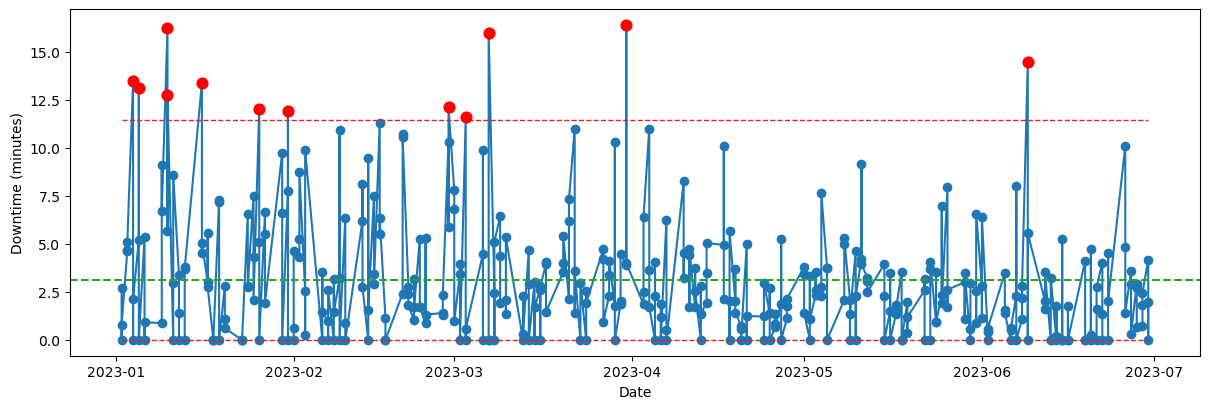

In [66]:
#I-MR for Downtime
df['Downtime_Mean'] = df['Downtime_Total'].mean()
df['MR_Downtime'] = df['Downtime_Total'].diff().abs()
MR_bar_Downtime = df['MR_Downtime'].mean()
df['UCL_Downtime'] = df['Downtime_Mean'] + 3 * (MR_bar_Downtime / 1.128)
df['LCL_Downtime'] = df['Downtime_Mean'] - 3 * (MR_bar_Downtime / 1.128)

plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Downtime_Total'], marker='o', linestyle='-', color='C0', label='Downtime Total')
plt.axhline(df['Downtime_Mean'].iloc[0], color='C2', linestyle='--', linewidth=1.5, label=f'Center Mean = {df["Downtime_Mean"].iloc[0]:.2f}')
plt.plot(df['Date'], df['UCL_Downtime'], color='C3', linestyle='--', linewidth=1, label='UCL')
plt.plot(df['Date'], df['LCL_Downtime'].clip(lower=0), color='C3', linestyle='--', linewidth=1, label='LCL (clipped at 0)')
ooc_mask_Downtime = (df['Downtime_Total'] > df['UCL_Downtime']) | (df['Downtime_Total'] < df['LCL_Downtime'])
plt.scatter(df['Date'][ooc_mask_Downtime], df['Downtime_Total'][ooc_mask_Downtime], color='red', s=60, zorder=5)
plt.tight_layout()
plt.ylabel('Downtime (minutes)')
plt.xlabel('Date')

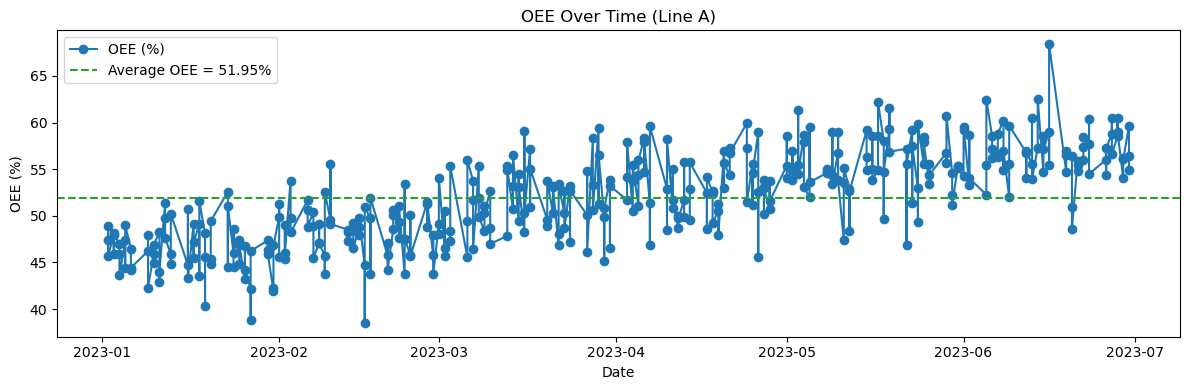

In [67]:
#OEE Chart
scheduled_time = 420  # Assuming 8-hour shifts (480 minutes)
optimal_cycle_time = df['Average_Cycle_Time'].mean() - df['Average_Cycle_Time'].std()  # Using mean - std as optimal
availability = (scheduled_time - df['Downtime_Total'])/scheduled_time  # Assuming 7-hour shifts (420 minutes)
performance = (optimal_cycle_time*df['Production_Volume'])/scheduled_time
quality = (df['Production_Volume']-df['Defects_Total'])/df['Production_Volume']
df['OEE'] = availability * performance * quality  # in percentage
average_oee = df['OEE'].mean()

plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['OEE'], marker='o', linestyle='-', color='C0', label='OEE (%)')
plt.axhline(average_oee, color='C2', linestyle='--', linewidth=1.5, label=f'Average OEE = {average_oee:.2f}%')
plt.title('OEE Over Time (Line A)')
plt.ylabel('OEE (%)')
plt.xlabel('Date')
plt.tight_layout()
plt.legend()

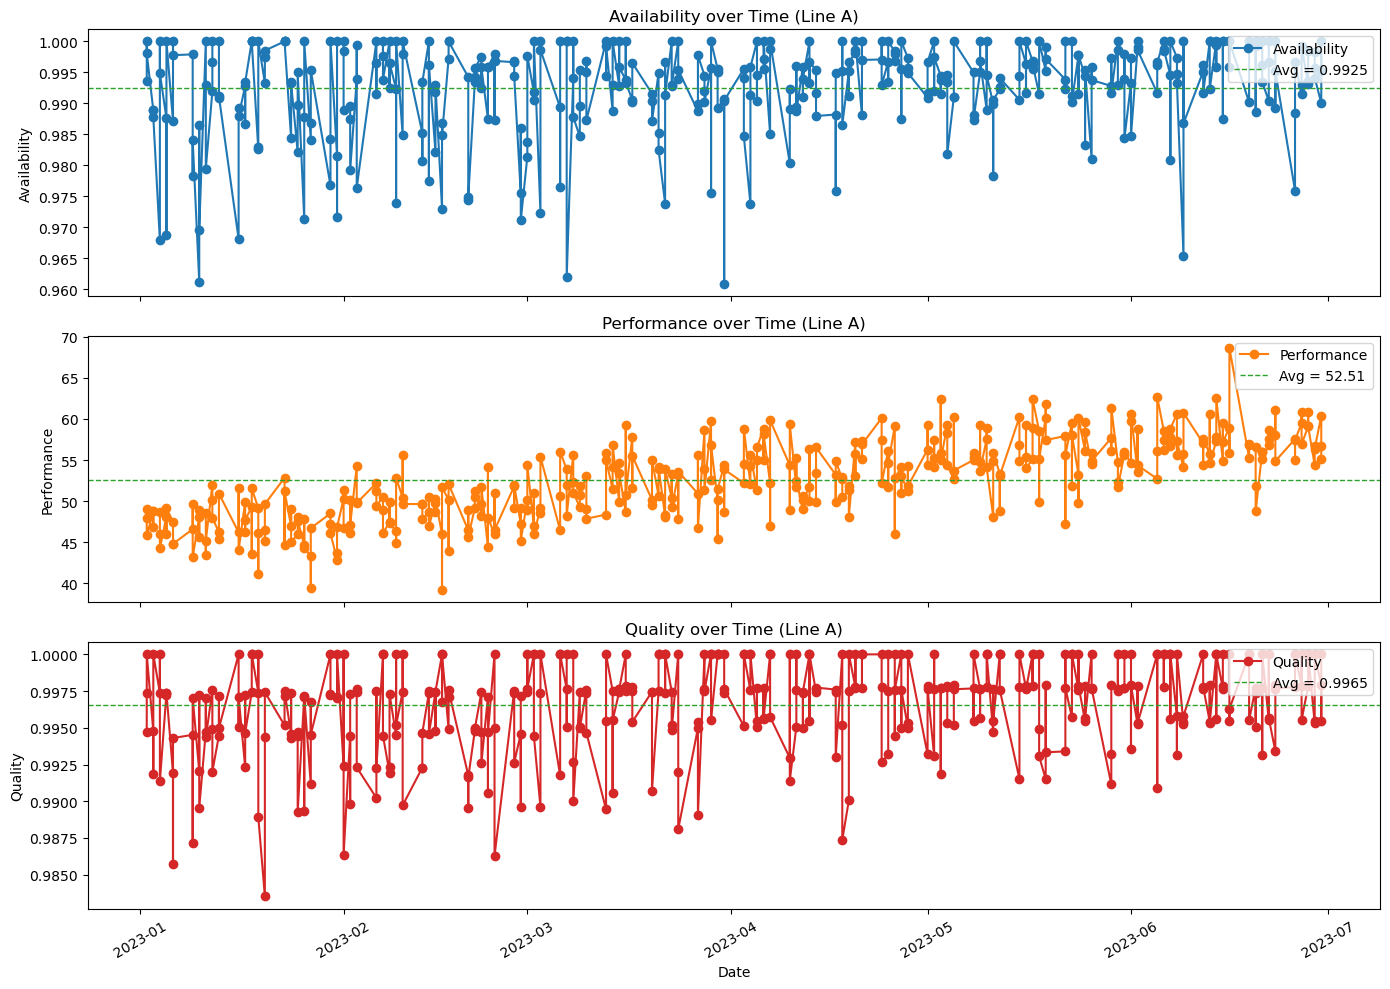

In [68]:
# Plot availability, performance, and quality individually for comparison
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(14, 10))

# Availability
axes[0].plot(x, availability, marker='o', linestyle='-', color='C0', label='Availability')
axes[0].axhline(availability.mean(), color='C2', linestyle='--', linewidth=1, label=f'Avg = {availability.mean():.4f}')
axes[0].set_ylabel('Availability')
axes[0].set_title('Availability over Time (Line A)')
axes[0].legend(loc='upper right')

# Performance
axes[1].plot(x, performance, marker='o', linestyle='-', color='C1', label='Performance')
axes[1].axhline(performance.mean(), color='C2', linestyle='--', linewidth=1, label=f'Avg = {performance.mean():.2f}')
axes[1].set_ylabel('Performance')
axes[1].set_title('Performance over Time (Line A)')
axes[1].legend(loc='upper right')

# Quality
axes[2].plot(x, quality, marker='o', linestyle='-', color='C3', label='Quality')
axes[2].axhline(quality.mean(), color='C2', linestyle='--', linewidth=1, label=f'Avg = {quality.mean():.4f}')
axes[2].set_ylabel('Quality')
axes[2].set_title('Quality over Time (Line A)')
axes[2].set_xlabel('Date')
axes[2].legend(loc='upper right')

plt.xticks(rotation=30)
plt.tight_layout()